# A2DI - TP5

## Exo 1 - Classifieur naïf bayésien et sac de mots

(Question 1)

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import scipy

# Permet l'affichage des graphiques
%matplotlib inline

data = scipy.io.loadmat('20news_w100.mat')
X = data['documents'].toarray()
c = data["newsgroups"][0]-1

print("Shape de X : {}".format(np.shape(X)))
print("Shape de c : {}".format(np.shape(c)))

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Shape de X : (100, 16242)
Shape de c : (16242,)


(Question 2)

In [2]:
n = np.shape(c)[0]
d = np.shape(X)[0]
n_class = len(np.bincount(c))

print("Nombre d'exemple : {}".format(n))
print("Nombre de dimension : {}".format(d))
print("Nombre de classe : {}".format(n_class))

Nombre d'exemple : 16242
Nombre de dimension : 100
Nombre de classe : 4


(Question 3)

In [3]:
# X_input : ensemble X d'exemple
# c_input : labels de X
# k       : nombre de pli
# n_class : nombre de class
def kfold_data(X_input, c_input, k, nb_class):
    # On transpose pour que ce soit plus pratique
    x_transpose = np.array(X_input).T

    # On commence par regrouper chaque exemple
    # par leurs labels respectifs
    x_by_labels = [[] for _ in range(nb_class)]
    for i in range(len(c_input)):
        x_by_labels[c_input[i]].append(x_transpose[i])
    
    # On crée les différents plis selon le nombre de 
    # chacune des classes
    size_pli_by_class = [0 for _ in range(nb_class)]
    rest_pli_by_class = [0 for _ in range(nb_class)]
    
    for i in range(nb_class):
        size_pli_by_class[i] = len(x_by_labels[i]) // k
        rest_pli_by_class[i] = len(x_by_labels[i]) % k
    
    k_plis = []
    
    # Chaque boucle crée un nouveau pli
    for i in range(k):
        xx = []
        yy = []

        for j in range(nb_class):
            xx += x_by_labels[j][i*size_pli_by_class[j]:(i+1)*size_pli_by_class[j]]
            yy += [j for _ in range(size_pli_by_class[j])]
        
        s = np.random.get_state()
        np.random.shuffle(xx)
        np.random.set_state(s)
        np.random.shuffle(yy)
        
        k_plis.append([xx, yy])
    
    # On ajoute le reste de chaque classe au dernier pli
    for j in range(nb_class):
        k_plis[-1][0] += x_by_labels[j][k*size_pli_by_class[j]:]
        k_plis[-1][1] += [j for _ in range(rest_pli_by_class[j])]
        
    # Pour finir on crée toutes les possibilités de répartition des
    # plis
    plis = [[] for _ in range(4)]
    
    for i in range(len(k_plis)):
        xx = []
        yy = []
        for j in range(len(k_plis)):
            if j != i:
                xx += k_plis[j][0]
                yy += k_plis[j][1]
        plis[0].append(np.array(xx).T)
        plis[1].append(np.array(yy))
        plis[2].append(np.array(k_plis[i][0]).T)
        plis[3].append(np.array(k_plis[i][1]))
        
    return plis[0], plis[1], plis[2], plis[3]

k = 3
k_plis = kfold_data(X, c, k, n_class)

(Question 4)

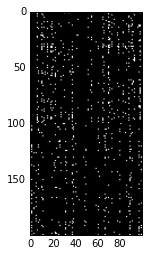

In [4]:
first_pli_x = k_plis[0][0].T
first_pli_y = k_plis[1][0]
hundred_class_0 = []
hundred_class_1 = []

for i in range(len(first_pli_y)):
    if len(hundred_class_0) == 100 and len(hundred_class_1) == 100:
        break
    
    if first_pli_y[i] == 0 and len(hundred_class_0) < 100:
        hundred_class_0.append(first_pli_x[i])
    elif first_pli_y[i] == 1 and len(hundred_class_1) < 100:
        hundred_class_1.append(first_pli_x[i])

to_display = np.vstack((hundred_class_0, hundred_class_1))
plt.imshow(to_display, cmap='gray')
plt.show()

Comme on le voit sur l'image dessiné au dessus, on peut observer pour les exemples de même classe des patterns assez abstrait. On voit bien qu'il y a des points communs qui sont différents selon la classe qu'on regarde. (Normalement on peut observer des "lignes" verticales). C'est grâce à ces patterns qu'on fait la différence entre les classes.

(Question 5)

In [5]:
# Tableau de taille 3x4 (3 = nb de pli, 4 = nb de classe)
proba_class_pli = [[] for _ in range(len(k_plis[0]))]

# Pour chaque pli
print("Répartition des probabilités des classes pour chaque pli :")
for p in range(len(k_plis[0])):
    rep_class = np.bincount(k_plis[1][p])
    for i in range(n_class):
        proba_class_pli[p].append(rep_class[i] / np.sum(rep_class))
    print("  Pli {} : {}".format(p, proba_class_pli[p]))

Répartition des probabilités des classes pour chaque pli :
  Pli 0 : [0.28349801459045154, 0.21664050235478807, 0.163634684643088, 0.33622679841167236]
  Pli 1 : [0.28349801459045154, 0.21664050235478807, 0.163634684643088, 0.33622679841167236]
  Pli 2 : [0.2835765749122483, 0.21670053574727507, 0.16349528911878811, 0.33622760022168852]


(Question 6)

In [6]:
# Tableau de taille 3x(100x4) (3 = nb de pli, 100 = nb de feature
# 4 = nb de classe)
proba_word_class_pli = [[] for _ in range(len(k_plis[0]))]

# Pour chaque pli
for p in range(len(k_plis[0])):
    rep_class = np.bincount(k_plis[1][p])
    rep_words = [np.array([0 for _ in range(d)]) for _ in range(n_class)]
    
    # Pour chaque exemple du pli
    for ex in range(np.shape(k_plis[0][p])[1]):
        index_class = k_plis[1][p][ex]

        for i in range(d):
            if k_plis[0][p][i][ex] == 1:
                rep_words[index_class][i] += 1

    # On divise par le nb de classe
    for i in range(n_class):
        rep_words[i] = rep_words[i] / rep_class[i]
    
    proba_word_class_pli[p] = rep_words

(Question 7)

In [7]:
# Pour chaque pli
error_by_pli = [0 for _ in range(len(k_plis[0]))]

for p in range(len(k_plis[0])):
    sadness = 0
    # Pour chaque exemple
    for ex in range(np.shape(k_plis[0][p])[1]):
        res = [proba_class_pli[p][i] for i in range(n_class)]
        
        # Pour chaque mot
        for m in range(d):
            if k_plis[0][p][m][ex] == 1:
                for cl in range(n_class):
                    res[cl] *= proba_word_class_pli[p][cl][m]

        # Si j'ai le mauvais résultat, je suis moins heureux
        if k_plis[1][p][ex] != np.argmax(res):
            sadness += 1

    error_by_pli[p] = sadness / np.shape(k_plis[0][p])[1]

print(error_by_pli)

[0.15892510850494043, 0.19503185889740512, 0.21623868464806947]


Au final on obtient un taux d'erreur qui varie de 15% à 21% environs.